In [42]:
import warnings
warnings.filterwarnings('ignore')

In [43]:
import scanpy as sc
adata = sc.read_10x_mtx("filtered_matrices_mex/hg19/", var_names='gene_symbols', make_unique=True)
print(adata.shape)


(68579, 32738)


In [44]:
import scanpy as sc

# For demonstration, load a smaller dataset (3k PBMCs) from scanpy’s library
# adata = sc.datasets.pbmc3k()  # 3k PBMC subset
print(f"Loaded dataset with {adata.n_obs} cells and {adata.n_vars} genes.")

# Basic filtering (if using full 68k data, which is already filtered by Cell Ranger)
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)
# (Optional) Filter out mitochondrial genes and cells with extreme counts if needed
# mito_genes = adata.var_names.str.startswith('MT-')
# adata.obs['pct_mito'] = np.sum(adata[:, mito_genes].X, axis=1).A1 / np.sum(adata.X, axis=1).A1 * 100
# adata = adata[adata.obs['pct_mito'] < 10]  # for example, remove cells with >10% mitochondrial genes

# Normalize counts per cell to a total of 1e4 and log-transform
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
# Identify highly variable genes (HVGs) for dimensionality reduction
sc.pp.highly_variable_genes(adata, n_top_genes=1000, subset=True)
adata = adata[:, adata.var['highly_variable']]

# Scale and perform PCA for dimensionality reduction
sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata, n_comps=50, svd_solver='arpack')
print(f"PCA completed. Shape of PCA scores: {adata.obsm['X_pca'].shape}")


Loaded dataset with 68579 cells and 32738 genes.
PCA completed. Shape of PCA scores: (68551, 500)


In [45]:
import numpy as np

N = 1000  # desired sketch size (e.g., 1000 cells)
np.random.seed(42)
uniform_indices = np.random.choice(adata.n_obs, size=N, replace=False)
adata_uniform = adata[uniform_indices].copy()
print(f"Uniformly sampled subset: {adata_uniform.n_obs} cells")


Uniformly sampled subset: 1000 cells


In [46]:
from geosketch import gs

X_pca = adata.obsm['X_pca']
N = 1000
sketch_indices = gs(X_pca, N, replace=False)
adata_geosketch = adata[sketch_indices].copy()
print(f"Geometric sketch subset: {adata_geosketch.n_obs} cells")


Geometric sketch subset: 1000 cells


In [47]:
from sklearn.cluster import KMeans

X_pca = adata.obsm['X_pca']
kmeans = KMeans(n_clusters=N, random_state=42)
cluster_labels = kmeans.fit_predict(X_pca)
centers = kmeans.cluster_centers_

# For each cluster, find the cell closest to the centroid
medoid_indices = []
for i in range(N):
    cluster_idx = np.where(cluster_labels == i)[0]
    if cluster_idx.size == 0:
        continue  # (should not happen if N ≤ number of cells)
    # distance from cluster centroid
    dist = np.sum((X_pca[cluster_idx] - centers[i])**2, axis=1)
    closest = cluster_idx[np.argmin(dist)]
    medoid_indices.append(closest)
medoid_indices = np.array(medoid_indices)
adata_kmedoids = adata[medoid_indices].copy()
print(f"K-Means medoids subset: {adata_kmedoids.n_obs} cells")


K-Means medoids subset: 1000 cells


In [49]:
# import time

# # Identify rare population (smallest cluster in full data)
# sc.pp.neighbors(adata, n_pcs=20)  # build kNN graph for clustering
# sc.tl.leiden(adata, resolution=1.0)
# cluster_counts = adata.obs['leiden'].value_counts()
# rare_cluster = cluster_counts.idxmin()  # cluster with fewest cells
# rare_count = cluster_counts.min()
# print(f"Rare cluster is {rare_cluster} with {rare_count} cells.")

# # Measure runtime and rare capture for each method
# methods = {'Uniform': uniform_indices, 'Geometric': sketch_indices, 'KMeans': medoid_indices}
# times = {}
# rare_capture = {}
# for name, idx in methods.items():
#     start = time.time()
#     # (Assume indices were obtained as above; here we just record elapsed time for fairness)
#     end = time.time()
#     times[name] = end - start
#     # Rare cell capture count:
#     rare_labels = adata.obs['leiden'][idx]
#     rare_capture[name] = (rare_labels == rare_cluster).sum()

# print("Runtime (s):", {k: f"{v:.4f}" for k,v in times.items()})
# print("Rare cluster capture:", rare_capture)


import time
import numpy as np
import matplotlib.pyplot as plt
from geosketch import gs
from sklearn.cluster import KMeans

# Ensure that 'leiden' clustering has been performed
sc.pp.neighbors(adata, n_pcs=20)
sc.tl.leiden(adata, resolution=1.0)

# Identify rare population (smallest cluster in full data)
cluster_counts = adata.obs['leiden'].value_counts()
rare_cluster = cluster_counts.idxmin()  # cluster with fewest cells
rare_count = cluster_counts.min()
print(f"Rare cluster is {rare_cluster} with {rare_count} cells.")

# Define sketch sizes
N_values = list(range(100, 2000, 200))

# Initialize dictionaries to store runtimes and rare cluster captures
times = {'Uniform': [], 'Geometric': [], 'KMeans': []}
rare_capture = {'Uniform': [], 'Geometric': [], 'KMeans': []}

# PCA-transformed data
X_pca = adata.obsm['X_pca']

for N in N_values:
    print(f"\nSketch size: {N}")

    # Uniform Sampling
    start = time.time()
    np.random.seed(42)
    uniform_indices = np.random.choice(X_pca.shape[0], size=N, replace=False)
    end = time.time()
    times['Uniform'].append(end - start)
    rare_labels = adata.obs['leiden'].iloc[uniform_indices]
    rare_capture['Uniform'].append((rare_labels == rare_cluster).sum())

    # Geometric Sketching
    start = time.time()
    sketch_indices = gs(X_pca, N, replace=False)
    end = time.time()
    times['Geometric'].append(end - start)
    rare_labels = adata.obs['leiden'].iloc[sketch_indices]
    rare_capture['Geometric'].append((rare_labels == rare_cluster).sum())

    # K-Means Medoids
    start = time.time()
    kmeans = KMeans(n_clusters=N, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(X_pca)
    centers = kmeans.cluster_centers_
    medoid_indices = []
    for i in range(N):
        cluster_idx = np.where(cluster_labels == i)[0]
        if cluster_idx.size == 0:
            continue
        dist = np.sum((X_pca[cluster_idx] - centers[i])**2, axis=1)
        closest = cluster_idx[np.argmin(dist)]
        medoid_indices.append(closest)
    end = time.time()
    times['KMeans'].append(end - start)
    rare_labels = adata.obs['leiden'].iloc[medoid_indices]
    rare_capture['KMeans'].append((rare_labels == rare_cluster).sum())

# Plotting Runtime
plt.figure(figsize=(10, 5))
for method in times:
    plt.plot(N_values, times[method], label=method, marker='o')
plt.xlabel('Sketch Size (N)')
plt.ylabel('Runtime (seconds)')
plt.title('Runtime vs. Sketch Size')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plotting Rare Cluster Capture
plt.figure(figsize=(10, 5))
for method in rare_capture:
    plt.plot(N_values, rare_capture[method], label=method, marker='s')
plt.xlabel('Sketch Size (N)')
plt.ylabel(f'Number of Cells from Rare Cluster ({rare_cluster})')
plt.title('Rare Cluster Capture vs. Sketch Size')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Rare cluster is 27 with 192 cells.

Sketch size: 100

Sketch size: 300


KeyboardInterrupt: 

/var/folders/6l/0rx8ckd168z5w8pkxrzqk9v80000gn/T/ipykernel_11277/3733696193.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  colors = full_labels.cat.codes[idx]  # numeric codes for categories


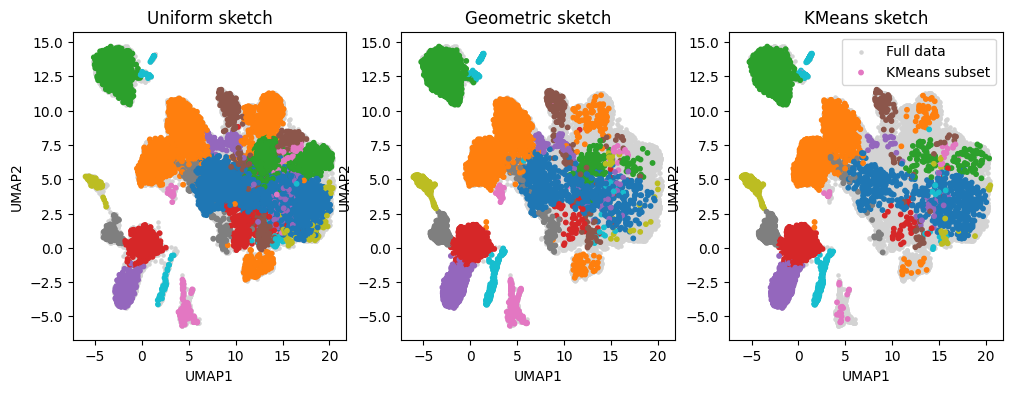

In [32]:
# Compute UMAP on full data
sc.tl.umap(adata, min_dist=0.5)
# Assign each cell a cluster label from full clustering
full_labels = adata.obs['leiden'].copy()

# UMAP coordinates
X_umap = adata.obsm['X_umap']
# Plot UMAP for each subset
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 3, figsize=(12,4))
for ax, (name, idx) in zip(axes, methods.items()):
    # plot full data in grey
    ax.scatter(X_umap[:,0], X_umap[:,1], c='lightgrey', s=5, label='Full data')
    # plot subset points colored by full cluster
    colors = full_labels.cat.codes[idx]  # numeric codes for categories
    scatter = ax.scatter(X_umap[idx,0], X_umap[idx,1], c=colors, cmap='tab10', s=10, label=f'{name} subset')
    ax.set_title(f"{name} sketch")
    ax.set_xlabel('UMAP1'); ax.set_ylabel('UMAP2')
plt.legend()
plt.show()


In [35]:
# Ensure that leiden labels from full data are added to the sketch
adata_geosketch.obs['leiden'] = adata.obs['leiden'][adata_geosketch.obs_names].values

# Ensure leiden clusters exist in full dataset
sc.pp.neighbors(adata, n_pcs=20)
sc.tl.leiden(adata, resolution=1.0)

# Add leiden labels to sketch object
adata_geosketch.obs['leiden'] = adata.obs['leiden'][adata_geosketch.obs_names].values

# Run differential expression
sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon')
sc.tl.rank_genes_groups(adata_geosketch, 'leiden', method='wilcoxon')

# Show top marker genes for a given cluster
cluster_id = '1'
print("Full data top markers for cluster", cluster_id, ":", adata.uns['rank_genes_groups']['names'][cluster_id][:3])
print("GeoSketch subset top markers for cluster", cluster_id, ":", adata_geosketch.uns['rank_genes_groups']['names'][cluster_id][:3])


/opt/homebrew/Cellar/jupyterlab/4.3.4_1/libexec/lib/python3.13/site-packages/scanpy/tools/_rank_genes_groups.py:484: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/opt/homebrew/Cellar/jupyterlab/4.3.4_1/libexec/lib/python3.13/site-packages/scanpy/tools/_rank_genes_groups.py:484: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/opt/homebrew/Cellar/jupyterlab/4.3.4_1/libexec/lib/python3.13/site-packages/scanpy/tools/_rank_genes_groups.py:484: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/opt/homebrew/Cellar/jupyterlab/4.3.4_1/libexec/lib/python3.13/site-packages/scanpy/tools/_rank_genes_groups.py:484: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/opt/homebrew/Cellar/jupyterlab/4.3.4_1/libexec/lib/python3.13/site-packages/scanpy/tools/_rank_genes_groups.py:484:

Full data top markers for cluster 1 : ['GZMK' 'CCL5' 'IL32']
GeoSketch subset top markers for cluster 1 : ['GZMK' 'IL32' 'CCL5']


/opt/homebrew/Cellar/jupyterlab/4.3.4_1/libexec/lib/python3.13/site-packages/scanpy/tools/_rank_genes_groups.py:484: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/opt/homebrew/Cellar/jupyterlab/4.3.4_1/libexec/lib/python3.13/site-packages/scanpy/tools/_rank_genes_groups.py:484: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/opt/homebrew/Cellar/jupyterlab/4.3.4_1/libexec/lib/python3.13/site-packages/scanpy/tools/_rank_genes_groups.py:484: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/opt/homebrew/Cellar/jupyterlab/4.3.4_1/libexec/lib/python3.13/site-packages/scanpy/tools/_rank_genes_groups.py:484: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/opt/homebrew/Cellar/jupyterlab/4.3.4_1/libexec/lib/python3.13/site-packages/scanpy/tools/_rank_genes_groups.py:484:

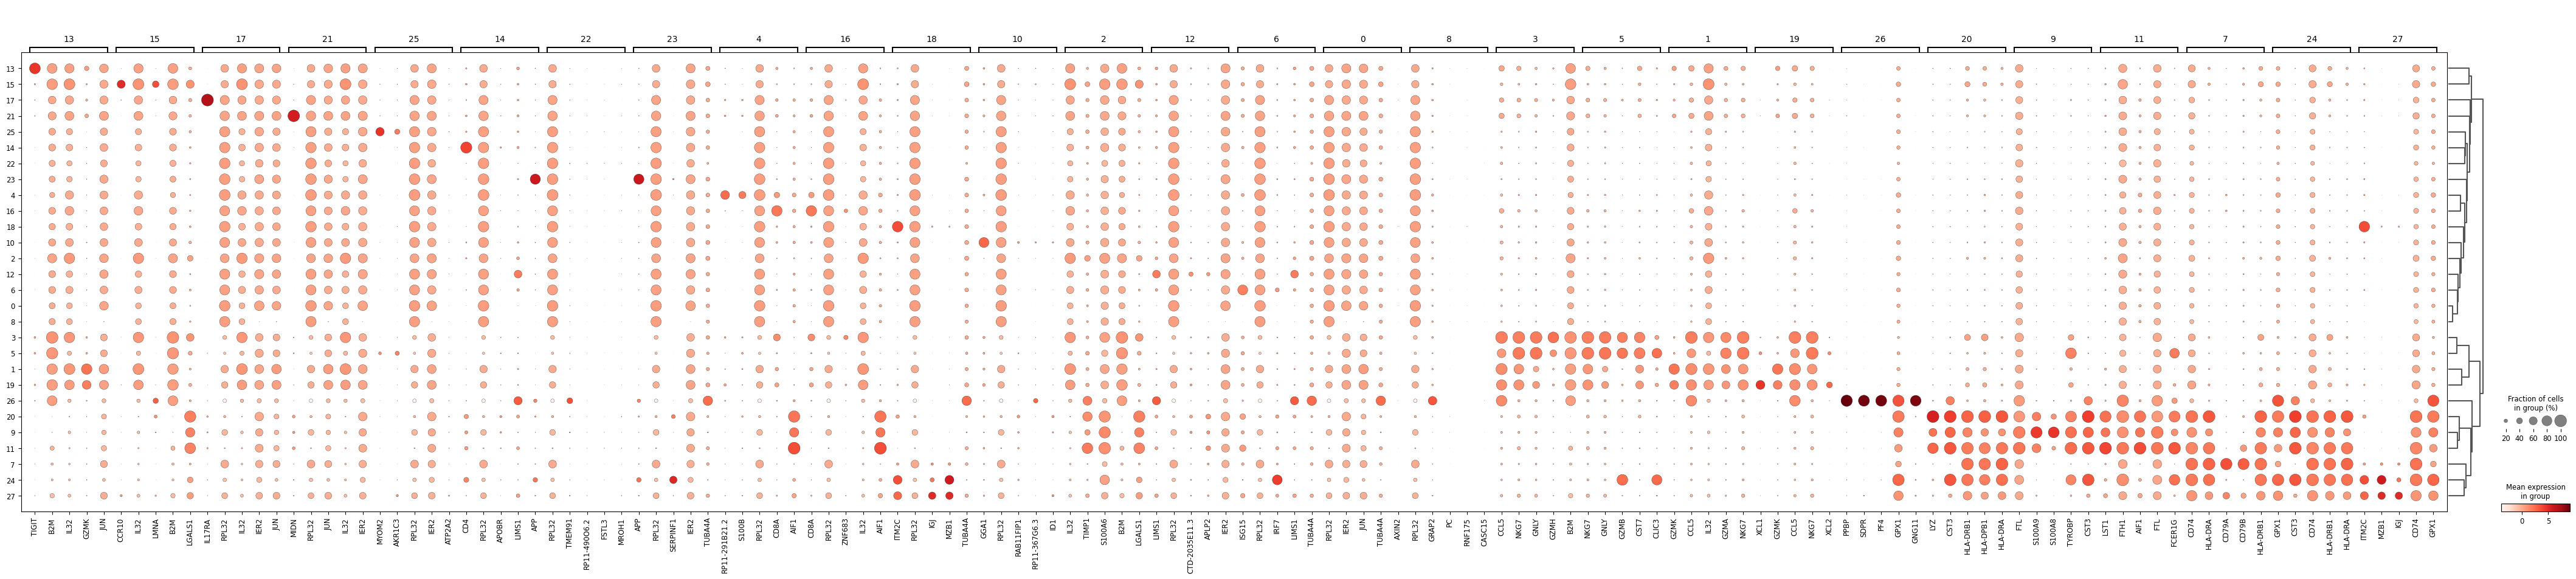

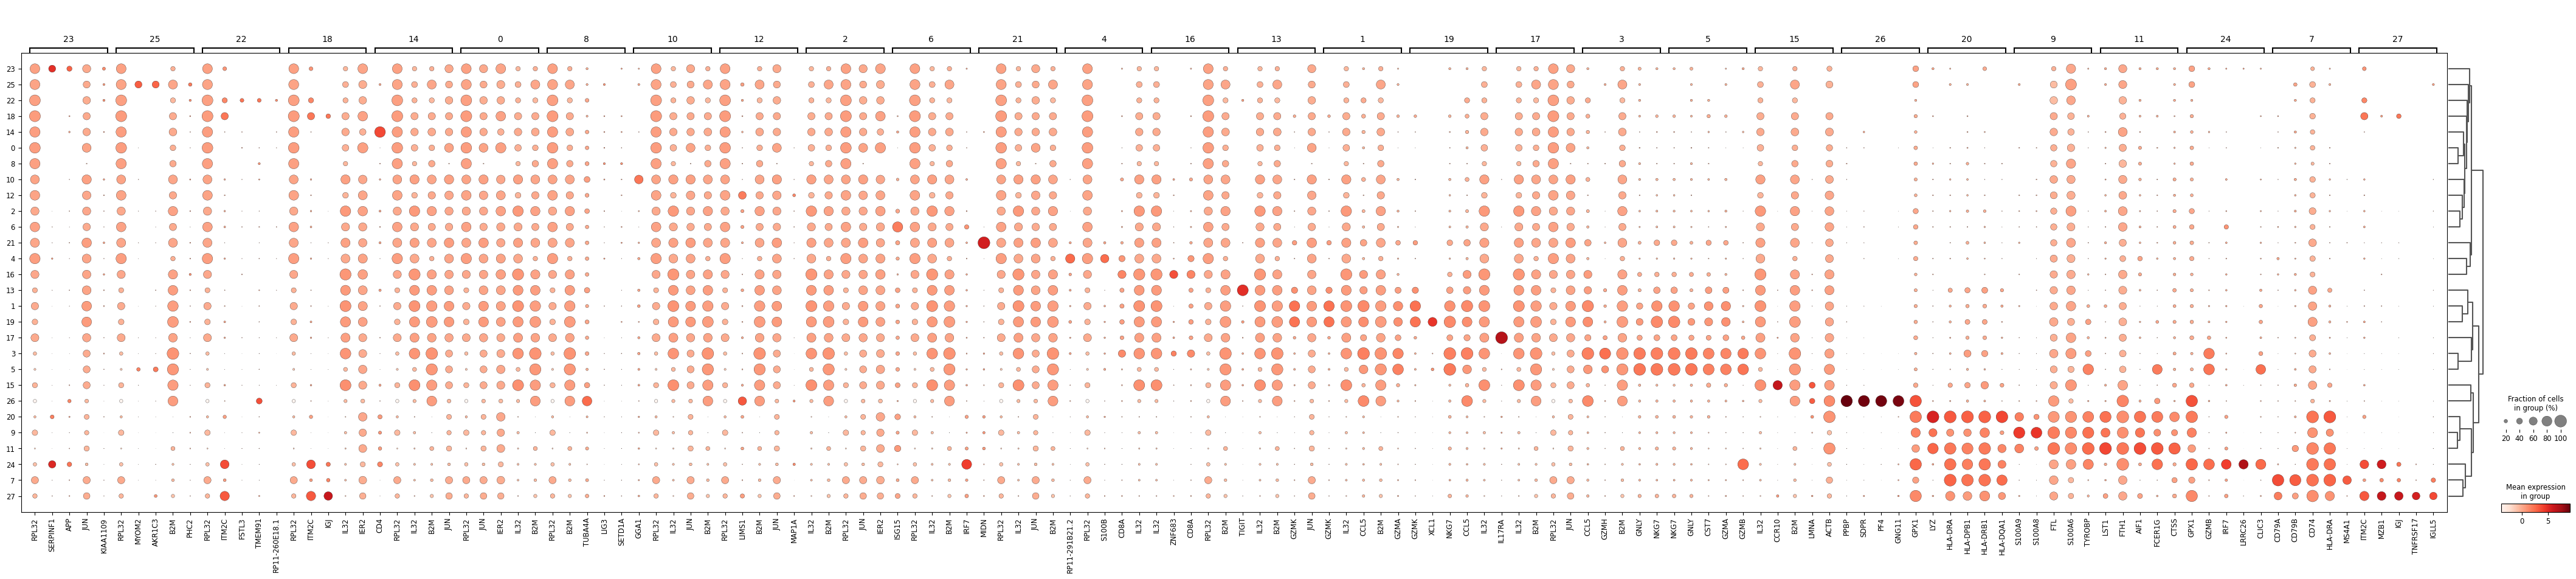

In [37]:
sc.pl.rank_genes_groups_dotplot(adata, n_genes=5)
sc.pl.rank_genes_groups_dotplot(adata_geosketch, n_genes=5)


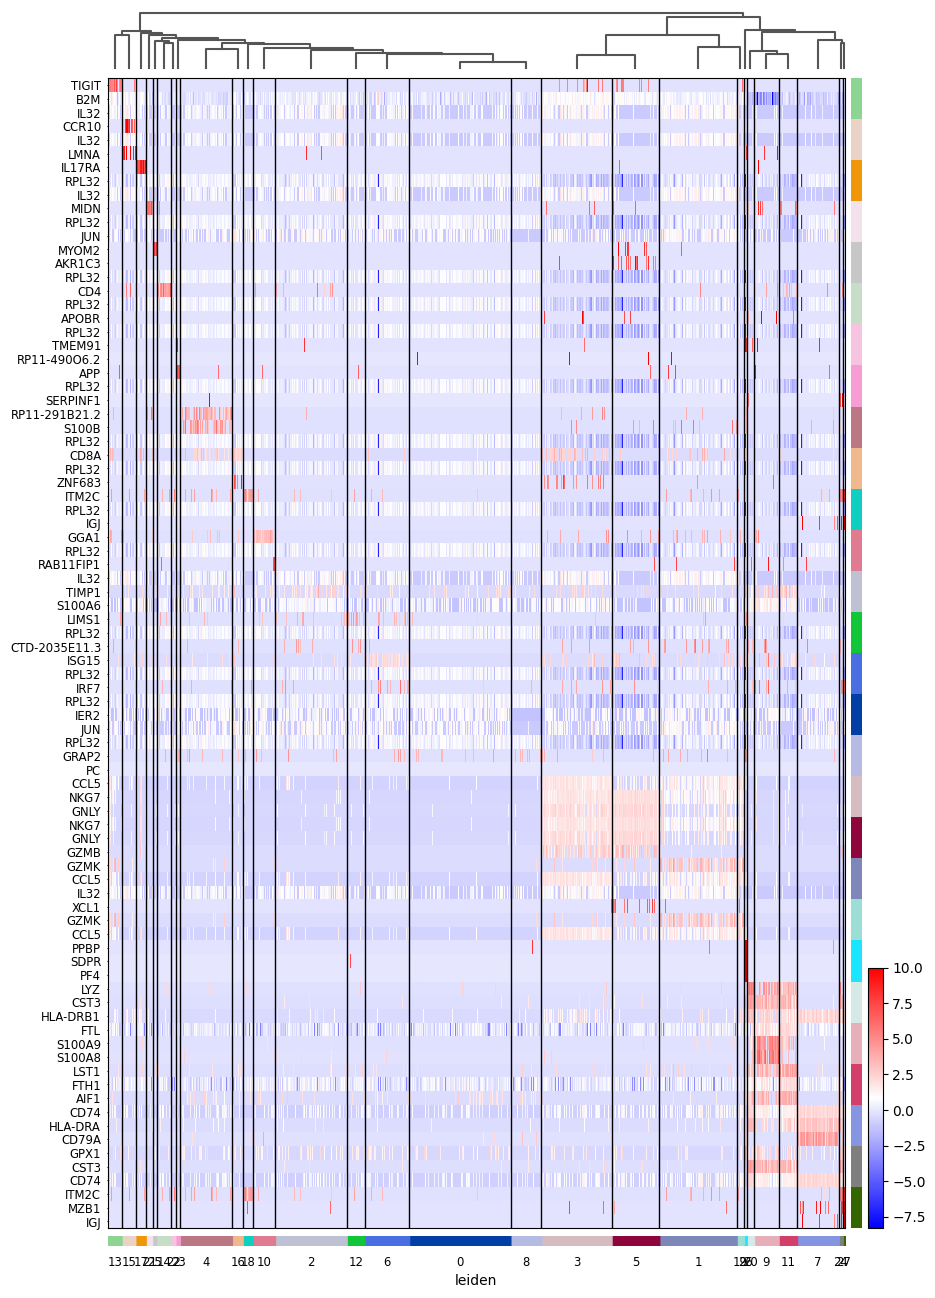

/opt/homebrew/Cellar/jupyterlab/4.3.4_1/libexec/lib/python3.13/site-packages/scanpy/tools/_rank_genes_groups.py:484: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/opt/homebrew/Cellar/jupyterlab/4.3.4_1/libexec/lib/python3.13/site-packages/scanpy/tools/_rank_genes_groups.py:484: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/opt/homebrew/Cellar/jupyterlab/4.3.4_1/libexec/lib/python3.13/site-packages/scanpy/tools/_rank_genes_groups.py:484: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/opt/homebrew/Cellar/jupyterlab/4.3.4_1/libexec/lib/python3.13/site-packages/scanpy/tools/_rank_genes_groups.py:484: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/opt/homebrew/Cellar/jupyterlab/4.3.4_1/libexec/lib/python3.13/site-packages/scanpy/tools/_rank_genes_groups.py:484:

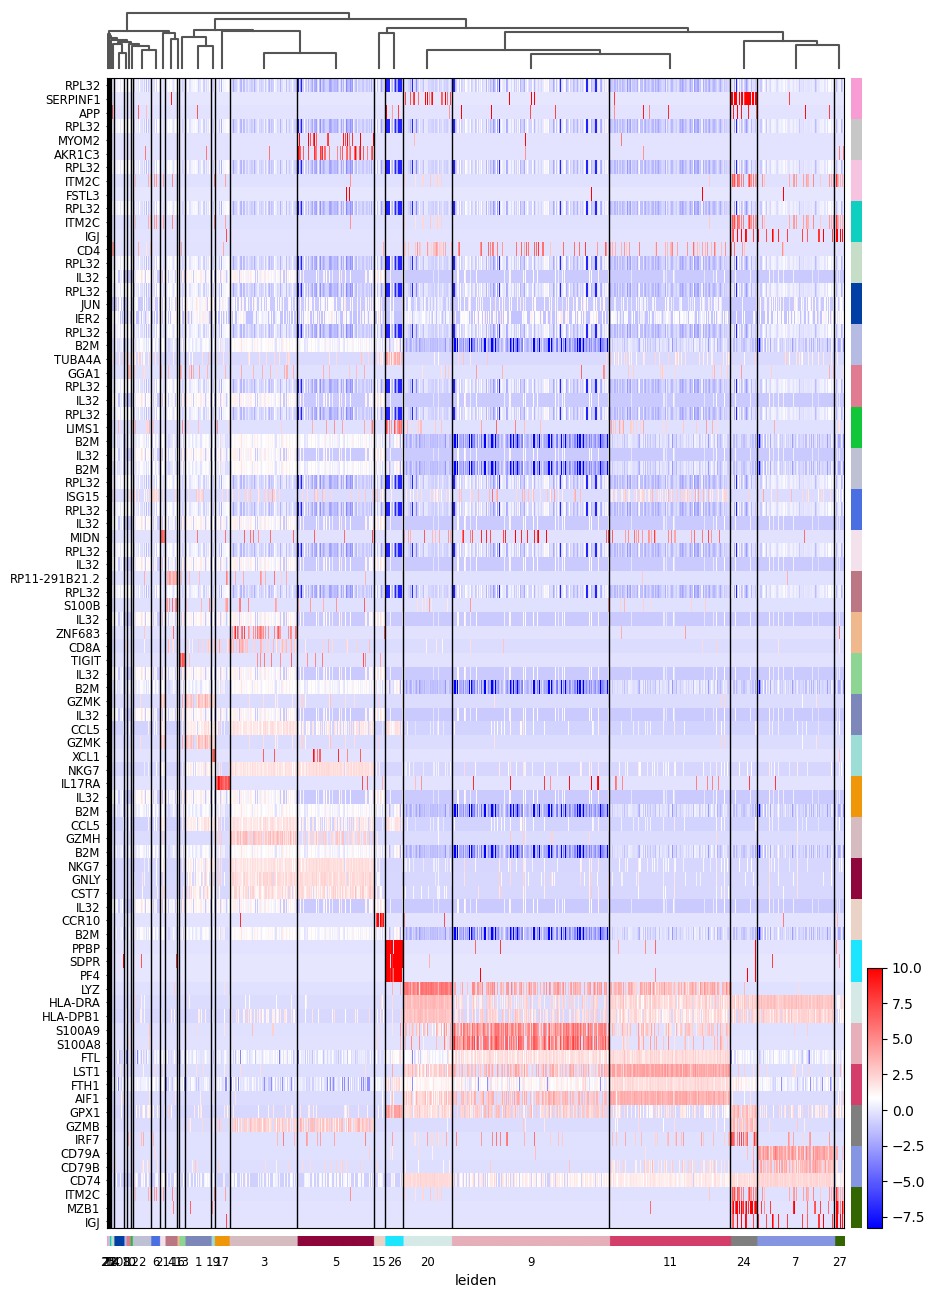

In [39]:
import scanpy as sc

# Ensure that differential expression has been computed
# sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon')  # Uncomment if not already done

# Plot heatmap for top 5 marker genes per cluster
sc.pl.rank_genes_groups_heatmap(
    adata,
    n_genes=3,
    groupby='leiden',
    show_gene_labels=True,
    cmap='bwr',
    swap_axes=True,
    dendrogram=True
)

# Ensure that 'leiden' labels are present in the subset
# adata_geosketch.obs['leiden'] = adata.obs['leiden'][adata_geosketch.obs_names].values  # Uncomment if not already done

# Compute differential expression for the sketch subset
sc.tl.rank_genes_groups(adata_geosketch, 'leiden', method='wilcoxon')

# Plot heatmap for top 5 marker genes per cluster in the sketch subset
sc.pl.rank_genes_groups_heatmap(
    adata_geosketch,
    n_genes=3,
    groupby='leiden',
    show_gene_labels=True,
    cmap='bwr',
    swap_axes=True,
    dendrogram=True
)


In [40]:
import time
import numpy as np
from geosketch import gs
from sklearn.cluster import KMeans

def measure_sketching_times(X_pca, N_values):
    times_uniform = []
    times_geosketch = []
    times_kmeans = []

    for N in N_values:
        # Uniform Sampling
        start = time.time()
        np.random.seed(42)
        uniform_indices = np.random.choice(X_pca.shape[0], size=N, replace=False)
        end = time.time()
        times_uniform.append(end - start)

        # Geometric Sketching
        start = time.time()
        sketch_indices = gs(X_pca, N, replace=False)
        end = time.time()
        times_geosketch.append(end - start)

        # K-Means Medoids
        start = time.time()
        kmeans = KMeans(n_clusters=N, random_state=42, n_init=10)
        cluster_labels = kmeans.fit_predict(X_pca)
        centers = kmeans.cluster_centers_
        medoid_indices = []
        for i in range(N):
            cluster_idx = np.where(cluster_labels == i)[0]
            if cluster_idx.size == 0:
                continue
            dist = np.sum((X_pca[cluster_idx] - centers[i])**2, axis=1)
            closest = cluster_idx[np.argmin(dist)]
            medoid_indices.append(closest)
        end = time.time()
        times_kmeans.append(end - start)

    return times_uniform, times_geosketch, times_kmeans


In [41]:
import matplotlib.pyplot as plt

# Define sketch sizes
N_values = list(range(100, 1100, 100))

# Assume X_pca is your PCA-transformed data matrix
# For example:
# X_pca = adata.obsm['X_pca']
X_pca = adata.obsm['X_pca']

# Measure runtimes
times_uniform, times_geosketch, times_kmeans = measure_sketching_times(X_pca, N_values)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(N_values, times_uniform, label='Uniform Sampling', marker='o')
plt.plot(N_values, times_geosketch, label='Geometric Sketching', marker='s')
plt.plot(N_values, times_kmeans, label='K-Means Medoids', marker='^')
plt.xlabel('Sketch Size (N)')
plt.ylabel('Runtime (seconds)')
plt.title('Runtime vs. Sketch Size for Different Sketching Methods')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


KeyboardInterrupt: 